<a href="https://colab.research.google.com/github/JoaoV2405/IC-Visao-Computacional/blob/main/modelos/DGCNNV_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)


!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install open3d
import open3d as o3d
# Helper functions for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from torch_geometric.transforms import FixedPoints

# !pip install open3d
!pip install numpy
import numpy as np
import torch
import pandas as pd
import os
from torch_geometric.data import Data, Dataset
from sklearn.preprocessing import MinMaxScaler


2.5.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 76.1 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting unin

In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 24.8 MB/s eta 0:00:00


In [ ]:
from typing import Callable, Optional, Union

import torch
from torch import Tensor

import torch_geometric.typing
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.inits import reset
from torch_geometric.typing import Adj, OptTensor, PairOptTensor, PairTensor

from torch_cluster import knn



class EdgeConv(MessagePassing):
    r"""The edge convolutional operator from the `"Dynamic Graph CNN for
    Learning on Point Clouds" <https://arxiv.org/abs/1801.07829>`_ paper.

    .. math::
        \mathbf{x}^{\prime}_i = \sum_{j \in \mathcal{N}(i)}
        h_{\mathbf{\Theta}}(\mathbf{x}_i \, \Vert \,
        \mathbf{x}_j - \mathbf{x}_i),

    where :math:`h_{\mathbf{\Theta}}` denotes a neural network, *.i.e.* a MLP.

    Args:
        nn (torch.nn.Module): A neural network :math:`h_{\mathbf{\Theta}}` that
            maps pair-wise concatenated node features :obj:`x` of shape
            :obj:`[-1, 2 * in_channels]` to shape :obj:`[-1, out_channels]`,
            *e.g.*, defined by :class:`torch.nn.Sequential`.
        aggr (str, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"max"`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.

    Shapes:
        - **input:**
          node features:math:`(|\mathcal{V}|, F_{in})` or
          :math:`((|\mathcal{V}|, F_{in}), (|\mathcal{V}|, F_{in}))`
          if bipartite,
          edge indices :math:`(2, |\mathcal{E}|)`
        - **output:** node features :math:`(|\mathcal{V}|, F_{out})` or
          :math:`(|\mathcal{V}_t|, F_{out})` if bipartite
    """
    def __init__(self, nn: Callable, aggr: str = 'max', **kwargs):
        super().__init__(aggr=aggr, **kwargs)
        self.nn = nn
        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        reset(self.nn)

    def forward(self, x: Union[Tensor, PairTensor], edge_index: Adj) -> Tensor:
        if isinstance(x, Tensor):
            x = (x, x)

        # propagate_type: (x: PairTensor)
        return self.propagate(edge_index, x=x)

    def message(self, x_i: Tensor, x_j: Tensor) -> Tensor:
        return self.nn(torch.cat([x_i, x_j - x_i], dim=-1))

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(nn={self.nn})'


class DynamicEdgeConv(MessagePassing):
    r"""The dynamic edge convolutional operator from the `"Dynamic Graph CNN
    for Learning on Point Clouds" <https://arxiv.org/abs/1801.07829>`_ paper
    (see :class:`torch_geometric.nn.conv.EdgeConv`), where the graph is
    dynamically constructed using nearest neighbors in the feature space.

    Args:
        nn (torch.nn.Module): A neural network :math:`h_{\mathbf{\Theta}}` that
            maps pair-wise concatenated node features :obj:`x` of shape
            `:obj:`[-1, 2 * in_channels]` to shape :obj:`[-1, out_channels]`,
            *e.g.* defined by :class:`torch.nn.Sequential`.
        k (int): Number of nearest neighbors.
        aggr (str, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"max"`)
        num_workers (int): Number of workers to use for k-NN computation.
            Has no effect in case :obj:`batch` is not :obj:`None`, or the input
            lies on the GPU. (default: :obj:`1`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.

    Shapes:
        - **input:**
          node features :math:`(|\mathcal{V}|, F_{in})` or
          :math:`((|\mathcal{V}|, F_{in}), (|\mathcal{V}|, F_{in}))`
          if bipartite,
          batch vector :math:`(|\mathcal{V}|)` or
          :math:`((|\mathcal{V}|), (|\mathcal{V}|))`
          if bipartite *(optional)*
        - **output:** node features :math:`(|\mathcal{V}|, F_{out})` or
          :math:`(|\mathcal{V}_t|, F_{out})` if bipartite
    """
    def __init__(self, nn: Callable, k: int, aggr: str = 'max',
                 num_workers: int = 1, **kwargs):
        super().__init__(aggr=aggr, flow='source_to_target', **kwargs)

        if knn is None:
            raise ImportError('`DynamicEdgeConv` requires `torch-cluster`.')

        self.nn = nn
        self.k = k
        self.num_workers = num_workers
        self.reset_parameters()

    def reset_parameters(self):
        reset(self.nn)

    def forward(
        self,
        x: Union[Tensor, PairTensor],
        batch: Union[OptTensor, Optional[PairTensor]] = None,
    ) -> Tensor:

        if isinstance(x, Tensor):
            x = (x, x)

        if x[0].dim() != 2:
            raise ValueError("Static graphs not supported in DynamicEdgeConv")

        b: PairOptTensor = (None, None)
        if isinstance(batch, Tensor):
            b = (batch, batch)
        elif isinstance(batch, tuple):
            assert batch is not None
            b = (batch[0], batch[1])

        edge_index = knn(x[0], x[1], self.k, b[0], b[1]).flip([0])

        # propagate_type: (x: PairTensor)
        return self.propagate(edge_index, x=x)

    def message(self, x_i: Tensor, x_j: Tensor) -> Tensor:
        return self.nn(torch.cat([x_i, x_j - x_i], dim=-1))

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(nn={self.nn}, k={self.k})'


In [ ]:
import torch

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: Tesla T4 is available.


In [ ]:
def normalize_point_cloud(point_cloud):
    # Centraliza os pontos
    centroid = point_cloud.mean(axis=0)
    point_cloud -= centroid

    # Normaliza para a esfera unitária
    max_distance = np.sqrt((point_cloud ** 2).sum(axis=1)).max()
    point_cloud /= max_distance

    return point_cloud

def z_score_normalization(point_cloud):
    mean = point_cloud.mean(axis=0)
    std = point_cloud.std(axis=0)
    # Evitar divisão por zero
    std[std == 0] = 1.0

    normalized_cloud = (point_cloud - mean) / std
    return normalized_cloud


def min_max_normalization(point_cloud, min_val=0, max_val=1):
    min_coords = point_cloud.min(axis=0)
    max_coords = point_cloud.max(axis=0)

    # Evitar divisão por zero (quando todos os pontos são iguais)
    scale = max_coords - min_coords
    scale[scale == 0] = 1.0

    normalized_cloud = (point_cloud - min_coords) / scale
    normalized_cloud = normalized_cloud * (max_val - min_val) + min_val
    return normalized_cloud

In [ ]:

class EggShellDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.data_frame = self.data_frame.drop(['C_GE'], axis=1)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Obtem o nome da nuvem de pontos na primeira coluna do arquivo csv
        ply_name = self.data_frame.iloc[idx, 0]
        ply_path = os.path.join(self.root_dir, ply_name)

        # Carregar a nuvem de pontos do arquivo PLY
        data = o3d.io.read_point_cloud(ply_path)
        normalized_point_cloud =normalize_point_cloud(np.asarray(data.points))
        pos = torch.tensor(normalized_point_cloud, dtype=torch.float)

        # Obter restante das medidas nas demais colunas do csv
        measurements = torch.tensor(self.data_frame.iloc[idx, 1:].values.astype('float'), dtype=torch.float)

        # Criar o sample como um objeto do tipo Data
        sample = Data(pos=pos, y=measurements.unsqueeze(0))

        if self.transform:
            sample = self.transform(sample)

        return sample






In [ ]:

def visualize_points(pos, edge_index=None, index=None):
    fig = plt.figure(figsize=(4, 4))
    if edge_index is not None:
        for (src, dst) in edge_index.t().tolist():
             src = pos[src].tolist()
             dst = pos[dst].tolist()
             plt.plot([src[0], dst[0]], [src[1], dst[1]], linewidth=1, color='black')
    if index is None:
        plt.scatter(pos[:, 0], pos[:, 1], s=50, zorder=1000)
    else:
       mask = torch.zeros(pos.size(0), dtype=torch.bool)
       mask[index] = True
       plt.scatter(pos[~mask, 0], pos[~mask, 1], s=50, color='lightgray', zorder=1000)
       plt.scatter(pos[mask, 0], pos[mask, 1], s=50, zorder=1000)
    plt.axis('off')
    plt.show()

Data(y=[1, 20], pos=[216, 3])
torch.Size([2, 1296])


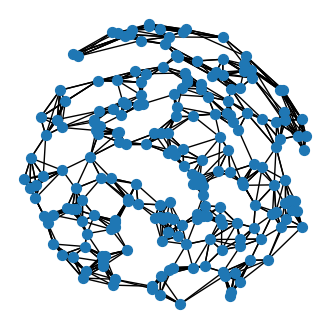

torch.Size([2, 1296])


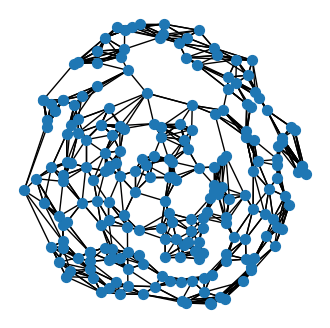

torch.Size([2, 1296])


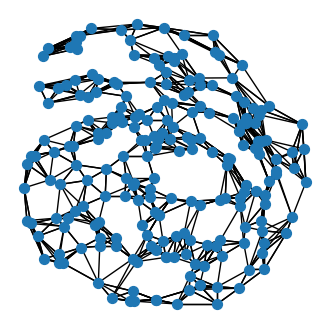

In [ ]:
from torch_cluster import knn_graph
transform = FixedPoints(num=216)
train_dataset = EggShellDataset(csv_file='/content/drive/MyDrive/Eggshell Dataset Completo/treino_reg.csv', root_dir='/content/drive/MyDrive/Eggshell Dataset Completo/ovos/', transform=transform)
sample = train_dataset[0]
print(sample)
sample.edge_index = knn_graph(sample.pos, k=6)
print(sample.edge_index.shape)
visualize_points(sample.pos, edge_index=sample.edge_index)

sample = train_dataset[4]
sample.edge_index = knn_graph(sample.pos, k=6)
print(sample.edge_index.shape)
visualize_points(sample.pos, edge_index=sample.edge_index)


sample = train_dataset[8]
sample.edge_index = knn_graph(sample.pos, k=6)
print(sample.edge_index.shape)
visualize_points(sample.pos, edge_index=sample.edge_index)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import  global_max_pool
from torch_cluster import knn
import torch.nn as nn

class DGCNN(torch.nn.Module):
    def __init__(self, k=20):
        super(DGCNN, self).__init__()

        self.conv1 = DynamicEdgeConv(torch.nn.Sequential(
            torch.nn.Linear(6, 64),
            nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64)
        ), k)

        self.conv2 = DynamicEdgeConv(torch.nn.Sequential(
            torch.nn.Linear(2 * 64, 128),
            nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128)
        ), k)

        self.fc1 = torch.nn.Linear(128, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.dp1 = torch.nn.Dropout(0.3)

        self.fc2 = torch.nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.dp2 = torch.nn.Dropout(0.3)

        self.fc3 = torch.nn.Linear(256, 17)
    def forward(self, x, batch):
        x = self.conv1(x, batch)
        x = self.conv2(x, batch)
        x = global_max_pool(x, batch)

        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dp1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dp2(x)

        x = self.fc3(x)
        return x
model = DGCNN()


In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
import torch.optim as optim
from torch_geometric.loader import DataLoader
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
import torch
from torch_cluster import knn_graph
from torch.optim.lr_scheduler import ReduceLROnPlateau


transform = FixedPoints(num=2048)
train_dataset = EggShellDataset(csv_file='/content/drive/MyDrive/Eggshell Dataset Completo/treino_sem_class.csv', root_dir='/content/drive/MyDrive/Eggshell Dataset Completo/ovos/', transform=transform)
test_dataset = EggShellDataset(csv_file='/content/drive/MyDrive/Eggshell Dataset Completo/teste_sem_class.csv', root_dir='/content/drive/MyDrive/Eggshell Dataset Completo/ovos/', transform=transform)


train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)
num_epochs = 30

model = DGCNN()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

criterion = torch.nn.L1Loss()



<IPython.core.display.Javascript object>

In [ ]:
# Train Loop
train_losses = []
test_losses = []
y_true_list = []
y_pred_list = []
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0

  for batch in train_loader:
    batch.pos = batch.pos.to(device)
    batch.batch = batch.batch.to(device)
    batch.y = batch.y.to(device)
    optimizer.zero_grad()
    outputs = model(batch.pos, batch.batch)
    loss = criterion(outputs, batch.y)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * batch.num_graphs

  total_loss = running_loss / len(train_loader.dataset)
  train_losses.append(total_loss)
  # scheduler.step(total_loss)
  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss}')



/usr/local/lib/python3.10/dist-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch [1/30], Loss: 22.9111347806891
Epoch [2/30], Loss: 12.694158033891158
Epoch [3/30], Loss: 7.251250911177251
Epoch [4/30], Loss: 6.581781951434304
Epoch [5/30], Loss: 6.640933711753127
Epoch [6/30], Loss: 6.581680766513283
Epoch [7/30], Loss: 6.403542071818545
Epoch [8/30], Loss: 6.329318229091225
Epoch [9/30], Loss: 6.306354574799728
Epoch [10/30], Loss: 6.493768730041893
Epoch [11/30], Loss: 6.3713442781135035
Epoch [12/30], Loss: 6.3287829687340595
Epoch [13/30], Loss: 6.343423738433984
Epoch [14/30], Loss: 6.321583255246115
Epoch [15/30], Loss: 6.280139229514382
Epoch [16/30], Loss: 6.334646460732395
Epoch [17/30], Loss: 6.189316482825332
Epoch [18/30], Loss: 6.166807447894338
Epoch [19/30], Loss: 6.1400786632556095
Epoch [20/30], Loss: 6.103115391312984
Epoch [21/30], Loss: 6.161182378277634
Epoch [22/30], Loss: 6.282382974404087
Epoch [23/30], Loss: 6.066130603899796
Epoch [24/30], Loss: 6.0898212344642655
Epoch [25/30], Loss: 6.099638169842284
Epoch [26/30], Loss: 6.1439614

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
r2_scores = []
mse_scores = []
test_losses = []
for epoch in range(30):
    model.eval()
    running_test_loss = 0.0
    y_true_list = []
    y_pred_list = []

    with torch.no_grad():
        for data in test_loader:
            data.pos = data.pos.to(device)
            data.batch = data.batch.to(device)
            data.y = data.y.to(device)

            # Fazendo a previsão
            outputs = model(data.pos, data.batch)

            # Calculando o erro da época
            test_loss = criterion(outputs, data.y)
            running_test_loss += test_loss.item() * data.num_graphs  # Corrigido para 'data.num_graphs'

            # Armazenando os valores verdadeiros e previstos
            y_true_list.append(data.y.cpu())  # Targets reais
            y_pred_list.append(outputs.cpu())  # Previsões do modelo

    # Calculando a perda média no teste
    total_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(total_test_loss)

    # Concatenando todas as previsões e os valores reais para calcular as métricas
    y_true = torch.cat(y_true_list, dim=0).numpy()
    y_pred = torch.cat(y_pred_list, dim=0).numpy()

    # Calculando R² e MSE
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Armazenando as métricas
    mse_scores.append(mse)
    r2_scores.append(r2)

    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {total_test_loss}, MSE: {mse}, R²: {r2}')


Epoch [1/30], Test Loss: 2.7893686449660686, MSE: 34.73542022705078, R²: -3.3753294944763184
Epoch [2/30], Test Loss: 2.8011385099373785, MSE: 32.20151138305664, R²: -2.9558584690093994
Epoch [3/30], Test Loss: 2.980064163309934, MSE: 39.372032165527344, R²: -4.497333526611328
Epoch [4/30], Test Loss: 2.766965695473341, MSE: 33.143184661865234, R²: -3.044736862182617
Epoch [5/30], Test Loss: 2.9021481149258666, MSE: 36.956321716308594, R²: -3.9800939559936523
Epoch [6/30], Test Loss: 2.759350526953275, MSE: 31.41590118408203, R²: -2.366420269012451
Epoch [7/30], Test Loss: 2.6254810996658295, MSE: 28.572364807128906, R²: -1.910364031791687
Epoch [8/30], Test Loss: 2.915146126623047, MSE: 42.32049560546875, R²: -5.100306987762451
Epoch [9/30], Test Loss: 2.8716645019205087, MSE: 35.94007110595703, R²: -3.514209032058716
Epoch [10/30], Test Loss: 2.7211116820463017, MSE: 31.03722381591797, R²: -2.4658379554748535
Epoch [11/30], Test Loss: 2.7753757477692953, MSE: 33.87960433959961, R²: -

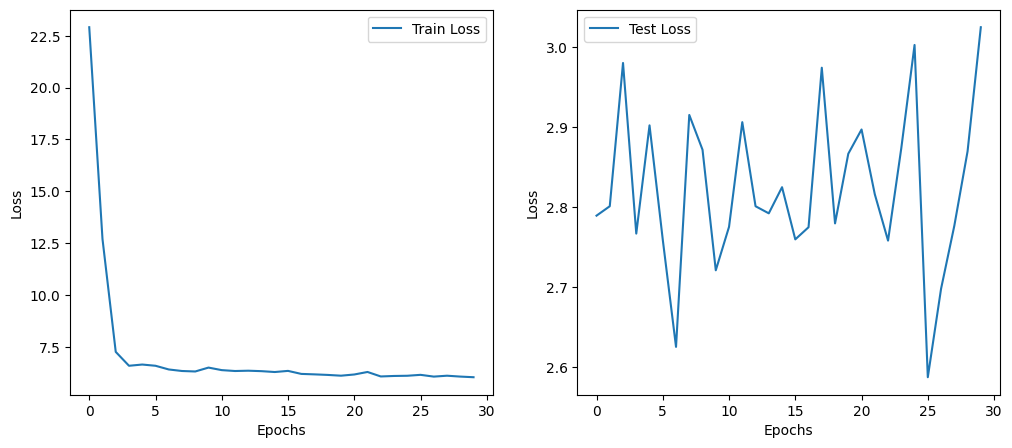

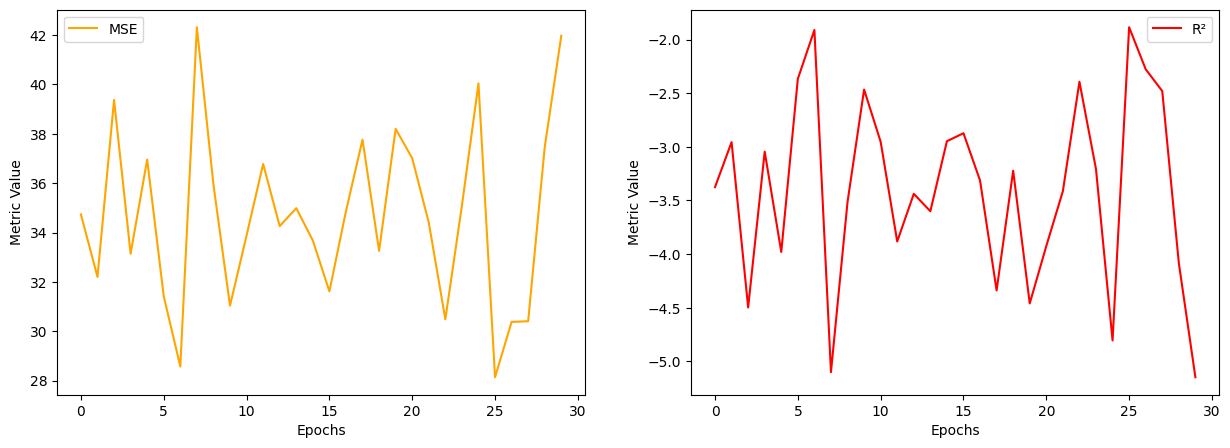

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(range(30), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Plotando MSE e R²
plt.subplot(1, 2, 1)

plt.plot(range(30), mse_scores, label='MSE', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(range(30), r2_scores, label='R²', color='red')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.legend()

plt.show()

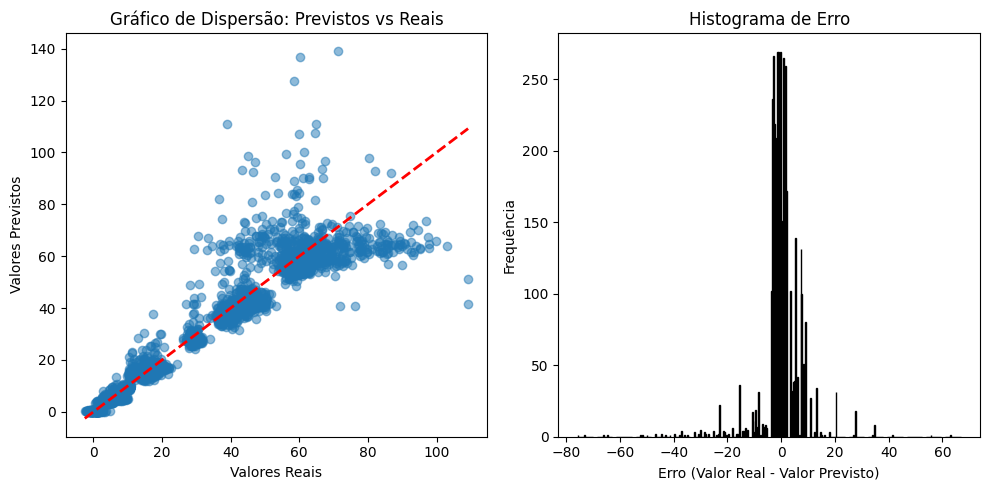

In [ ]:
import matplotlib.pyplot as plt

# Função para plotar o gráfico de dispersão e o histograma de erro
def plot_predictions_vs_actuals(y_true, y_pred):
    # Gráfico de dispersão
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', linewidth=2)
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Previstos')
    plt.title('Gráfico de Dispersão: Previstos vs Reais')

    # Histograma de erro
    erros = y_true - y_pred
    plt.subplot(1, 2, 2)
    plt.hist(erros, bins=20, edgecolor='black')
    plt.xlabel('Erro (Valor Real - Valor Previsto)')
    plt.ylabel('Frequência')
    plt.title('Histograma de Erro')

    plt.tight_layout()
    plt.show()



# y_true_np = y_true_list.detach().cpu().numpy()
# y_pred_np = y_pred_list.detach().cpu().numpy()
plot_predictions_vs_actuals(y_true, y_pred)


In [ ]:
print(y_true[10])
print(y_pred[10])

[ 68.6    10.      9.7    17.766  19.    109.1     0.174  97.7     3.61
   5.56    0.36   57.27   47.07    0.45   28.64   14.32   38.05 ]
[59.392       5.03187     9.518327   17.257397   15.036347   41.542297
  0.36492488 64.79163     3.7387645   5.5411553   0.36397636 55.728115
 42.34349     0.15281588 28.015448   14.05257    36.737194  ]
